In [3]:
!git clone https://github.com/Jjioo/NLP_data

Cloning into 'NLP_data'...
remote: Enumerating objects: 108, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 108 (delta 20), reused 108 (delta 20), pack-reused 0
Receiving objects: 100% (108/108), 60.44 KiB | 2.16 MiB/s, done.
Resolving deltas: 100% (20/20), done.


In [7]:
%cd ..
%pwd

/content/NLP_data


'/content/NLP_data'

In [50]:
import pandas as pd

# Load information about tasks and categories
file_info = pd.read_csv('/content/NLP_data/csv_folder/file_information.csv')
test_info = pd.read_csv('/content/NLP_data/csv_folder/test_info.csv')

# Load text data
txt_files = [doc for doc in os.listdir('/content/NLP_data/txt_data') if doc.endswith('.txt')]
txt_content = [open(os.path.join('/content/NLP_data/txt_data', _file), encoding='utf-8', errors='ignore').read()
               for _file in txt_files]


**Preprocess Text Data:**

In [51]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(txt_content)

# Convert text data to sequences
sequences = tokenizer.texts_to_sequences(txt_content)

# Pad sequences to a fixed length
max_seq_length = 100  # Adjust as needed
padded_sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post', truncating='post')


**Train, Validation, and Test Sets:**

In [55]:
# Assuming 'Category' column in file_info indicates plagiarism
labels = (file_info['Category'] == 'non').astype(int)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

**LSTM Model:**

In [56]:

# Define the LSTM model
embedding_dim = 50
vocab_size = len(tokenizer.word_index) + 1
lstm_units = 100

lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_seq_length))
lstm_model.add(LSTM(units=lstm_units, return_sequences=True))  # Return sequences for more context
lstm_model.add(LSTM(units=lstm_units))  # Additional LSTM layer
lstm_model.add(Dense(1, activation='sigmoid'))

# Compile the model
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the summary of the model
lstm_model.summary()

# Train the model
epochs = 20  # Increase the number of epochs
batch_size = 32  # Adjust as needed
lstm_model.fit(X_train, y_train, epochs=epochs, validation_split=0.1, batch_size=batch_size)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 100, 50)           107450    
                                                                 
 lstm_7 (LSTM)               (None, 100, 100)          60400     
                                                                 
 lstm_8 (LSTM)               (None, 100)               80400     
                                                                 
 dense_9 (Dense)             (None, 1)                 101       
                                                                 
Total params: 248351 (970.12 KB)
Trainable params: 248351 (970.12 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
3/3 [==============================] - 7s 620ms/step - loss: 0.6903 - accuracy: 0.5278 - val_loss: 0.6952 - val_accuracy: 0.5000
Epoch

**CNN Model:**

In [57]:
# Define the CNN model
embedding_dim = 50
vocab_size = len(tokenizer.word_index) + 1
num_filters = 64
filter_size = 3

cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_seq_length))
cnn_model.add(Conv1D(filters=num_filters, kernel_size=filter_size, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the summary of the model
cnn_model.summary()

# Train the model
epochs = 20
batch_size = 32
cnn_model.fit(X_train, y_train, epochs=epochs, validation_split=0.1, batch_size=batch_size)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 100, 50)           107450    
                                                                 
 conv1d_2 (Conv1D)           (None, 98, 64)            9664      
                                                                 
 global_max_pooling1d_2 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 117179 (457.73 KB)
Trainable params: 117179 (457.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
3/3 [==============================] - 1s 110ms/step - loss: 0.6803 

In [58]:
# Save LSTM model
lstm_model.save('lstm_model.h5')
# Save CNN model
cnn_model.save('cnn_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [62]:
!git remote -v

origin	https://github.com/Jjioo/NLP_data (fetch)
origin	https://github.com/Jjioo/NLP_data (push)


In [63]:
!git remote set-url origin git@github.com:Jjioo/NLP_data.git

1/1 [==============================] - 0s 109ms/step


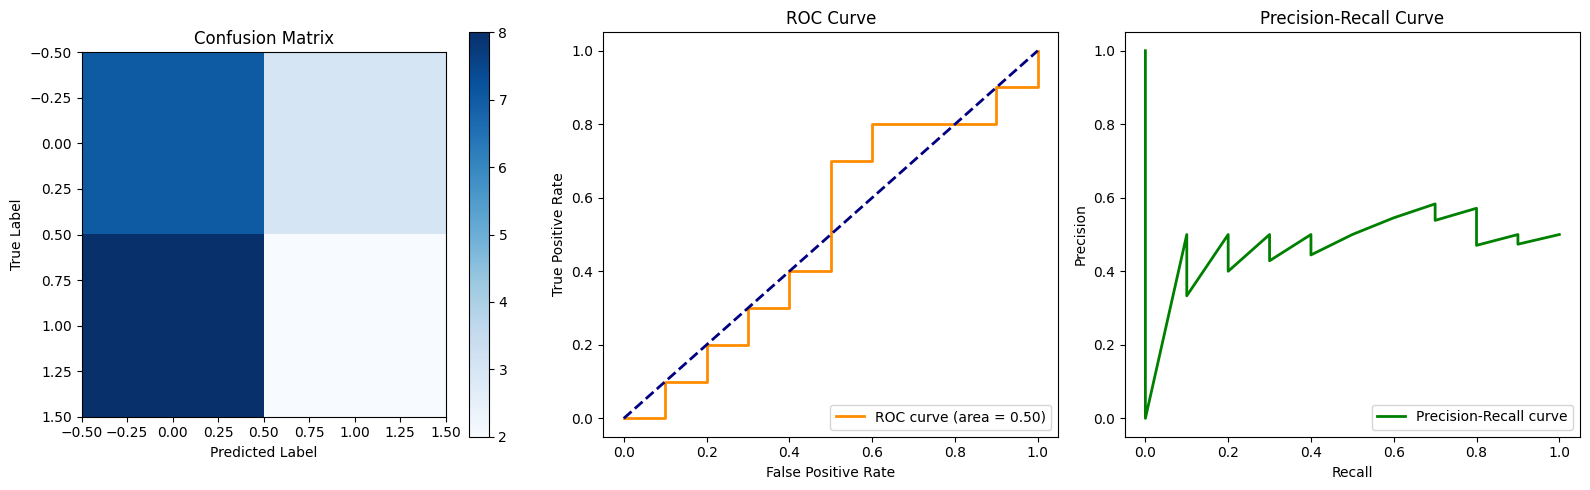

In [75]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, f1_score, accuracy_score
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = (lstm_model.predict(X_test) > 0.5).astype("int32")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)


# ROC Curve
fpr, tpr, _ = roc_curve(y_test, lstm_model.predict(X_test))
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, lstm_model.predict(X_test))

# Calculate F1 Score and Accuracy
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Plotting
plt.figure(figsize=(16, 5))

# Confusion Matrix
plt.subplot(1, 3, 1)
plt.imshow(conf_matrix, cmap='Blues', interpolation='None')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# ROC Curve
plt.subplot(1, 3, 2)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

# Precision-Recall Curve
plt.subplot(1, 3, 3)
plt.plot(recall, precision, color='green', lw=2, label='Precision-Recall curve')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower right")

# Show metrics
plt.tight_layout()
plt.show()



In [77]:
from prettytable import PrettyTable
from sklearn.metrics import precision_score, recall_score

# Make predictions on the test set for both models
y_pred_lstm = (lstm_model.predict(X_test) > 0.5).astype("int32")
y_pred_cnn = (cnn_model.predict(X_test) > 0.5).astype("int32")

# Calculate metrics for both models
metrics_lstm = {
    'Precision': precision_score(y_test, y_pred_lstm),
    'Recall': recall_score(y_test, y_pred_lstm),
    'F1 Score': f1_score(y_test, y_pred_lstm),
    'Accuracy': accuracy_score(y_test, y_pred_lstm)
}

metrics_cnn = {
    'Precision': precision_score(y_test, y_pred_cnn),
    'Recall': recall_score(y_test, y_pred_cnn),
    'F1 Score': f1_score(y_test, y_pred_cnn),
    'Accuracy': accuracy_score(y_test, y_pred_cnn)
}

# Confusion Matrix for both models
conf_matrix_lstm = confusion_matrix(y_test, y_pred_lstm)
conf_matrix_cnn = confusion_matrix(y_test, y_pred_cnn)

# Display metrics in a table
table = PrettyTable()
table.field_names = ["Metric", "LSTM Model", "CNN Model"]
table.add_row(["Precision", metrics_lstm['Precision'], metrics_cnn['Precision']])
table.add_row(["Recall", metrics_lstm['Recall'], metrics_cnn['Recall']])
table.add_row(["F1 Score", metrics_lstm['F1 Score'], metrics_cnn['F1 Score']])
table.add_row(["Accuracy", metrics_lstm['Accuracy'], metrics_cnn['Accuracy']])

print("Metrics for LSTM and CNN Models:")
print(table)

# Display Confusion Matrix for both models
print("\nConfusion Matrix for LSTM Model:")
print(conf_matrix_lstm)

print("\nConfusion Matrix for CNN Model:")
print(conf_matrix_cnn)


1/1 [==============================] - 0s 66ms/step
Metrics for LSTM and CNN Models:
+-----------+---------------------+-----------+
|   Metric  |      LSTM Model     | CNN Model |
+-----------+---------------------+-----------+
| Precision |         0.4         |    0.0    |
|   Recall  |         0.2         |    0.0    |
|  F1 Score | 0.26666666666666666 |    0.0    |
|  Accuracy |         0.45        |    0.5    |
+-----------+---------------------+-----------+

Confusion Matrix for LSTM Model:
[[7 3]
 [8 2]]

Confusion Matrix for CNN Model:
[[10  0]
 [10  0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [78]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [79]:
!mv lstm_model.h5 /content/drive/MyDrive/
!mv cnn_model.h5 /content/drive/MyDrive/

In [80]:
from tensorflow.keras.models import load_model

# Load LSTM model
lstm_model = load_model('/content/drive/MyDrive/lstm_model.h5')

# Load CNN model
cnn_model = load_model('/content/drive/MyDrive/cnn_model.h5')


In [87]:
import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def preprocess_file_content(file_path):
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
        content = file.read()

    # Tokenization and removing stop words (adjust as needed)
    tokens = word_tokenize(content)
    tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stopwords.words('english')]

    # Join tokens back into a string
    preprocessed_content = ' '.join(tokens)

    return preprocessed_content


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [89]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [90]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def preprocess_file_content(file_path):
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
        content = file.read()

    # Tokenization and removing stop words (adjust as needed)
    tokens = word_tokenize(content)
    tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stopwords.words('english')]

    # Join tokens back into a string
    preprocessed_content = ' '.join(tokens)

    return preprocessed_content


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [91]:
# Assuming you have loaded your LSTM and CNN models as lstm_model and cnn_model

# Define the plagiarism threshold
plagiarism_threshold = 0.5

# Path to your test file
test_file_path = 'test.txt'

# Preprocess the content of the test file
test_file_content = preprocess_file_content(test_file_path)

# Convert the preprocessed content to sequences and pad
test_sequence = tokenizer.texts_to_sequences([test_file_content])
padded_sequence = pad_sequences(test_sequence, maxlen=max_seq_length, padding='post')

# Make predictions with LSTM model
lstm_prediction = lstm_model.predict(padded_sequence)

# Make predictions with CNN model
cnn_prediction = cnn_model.predict(padded_sequence)

# Determine plagiarism status based on the threshold
lstm_result = "Plagiarism" if lstm_prediction > plagiarism_threshold else "Not Plagiarism"
cnn_result = "Plagiarism" if cnn_prediction > plagiarism_threshold else "Not Plagiarism"

# Print the results
print("LSTM Model Prediction:", lstm_result)
print("CNN Model Prediction:", cnn_result)


1/1 [==============================] - 0s 232ms/step
LSTM Model Prediction: Not Plagiarism
CNN Model Prediction: Not Plagiarism
